# HW2 - Algorithm Implementation and Basic Model Selection

## Imports & Style edit

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
# from sklearn.model_selection import train_test_split
# from matplotlib.pyplot import semilogx
# from sklearn.svm import SVC

In [126]:
# Required test style for matplotlib.
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [127]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

## Preliminary: Data Loading

In [128]:
# !rm *.csv

# from google.colab import files
# print("Please load the modified Traing set csv data")
# uploadedData = files.upload()
# training_set_file = list(uploadedData)[0]

# print("Please load the modified Test set csv data")
# uploadedData = files.upload()
# test_set_file = list(uploadedData)[0]
training_set_file = "training_set.csv"
test_set_file = "test_set.csv"

In [129]:
training_set = pd.read_csv(training_set_file)
test_set = pd.read_csv(test_set_file)

## Part 1: Basic model selection with k-Nearest Neighbors

### Visualization and basic analysis

train 1.0


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


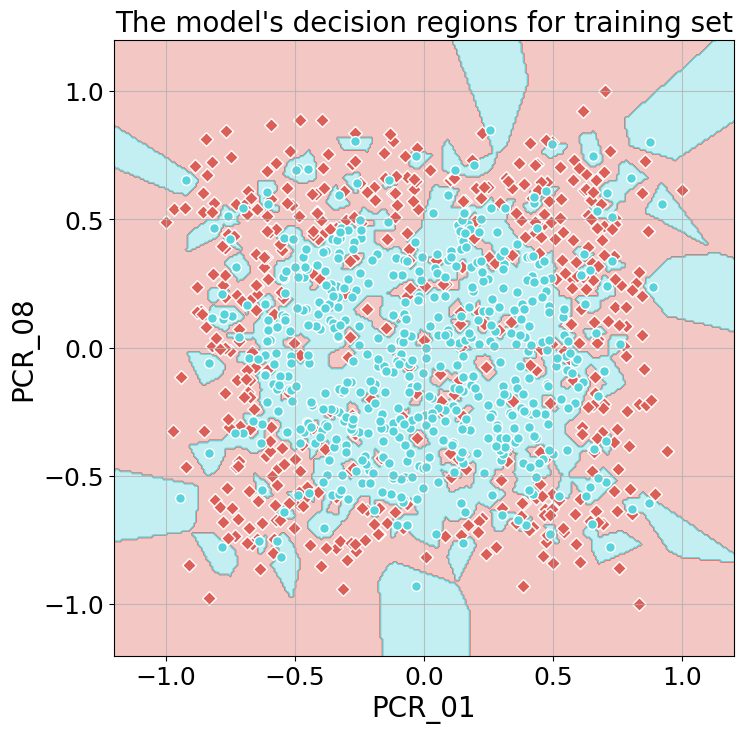

test 0.7


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


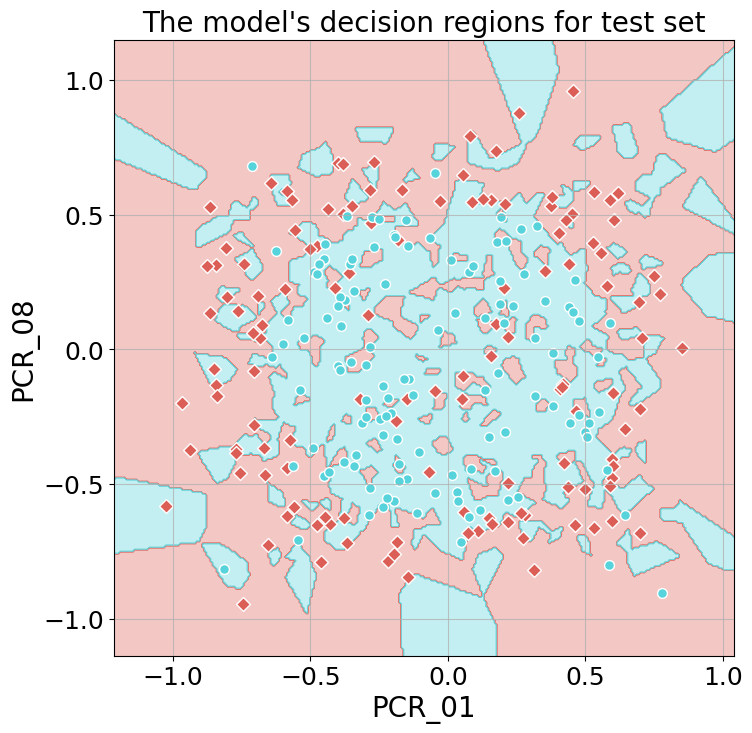

In [130]:
# Q1

# Create dataframe containing only the PCR 01 & 08 values
training_set_01_08 = training_set[['PCR_01', 'PCR_08']]
test_set_01_08 = test_set[['PCR_01', 'PCR_08']]

# Create kNN classifier with k=1
kNNClassifier = KNeighborsClassifier(n_neighbors=1)
kNNClassifier.fit(training_set_01_08, training_set['spread'])

# Visualize the decision regions for training set
print("train", kNNClassifier.score(training_set_01_08, training_set["spread"]))
visualize_clf(kNNClassifier, training_set_01_08, training_set['spread'], "The model's decision regions for training set", 'PCR_01', 'PCR_08')

# Visualize the decision regions for test set
print("test", kNNClassifier.score(test_set_01_08, test_set["spread"]))
visualize_clf(kNNClassifier, test_set_01_08, test_set['spread'], "The model's decision regions for test set", 'PCR_01', 'PCR_08')

### Model selection

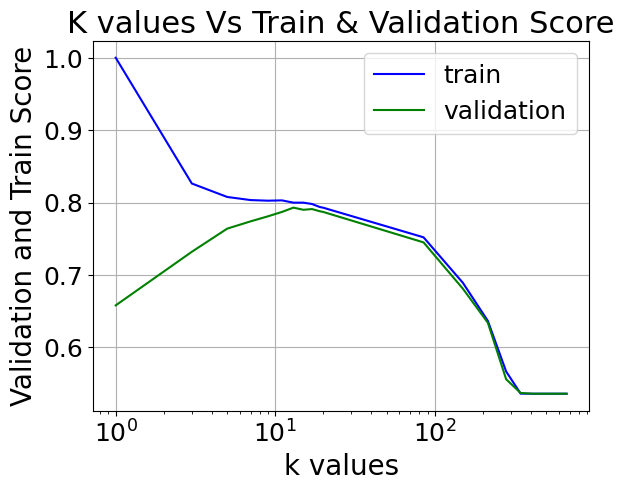

K: 13 Validation score: 0.793 Train score: 0.7998571428571429


In [131]:
# Q2

# create list of options for the k value
k_options = list(range(1, 20, 2)) + list(range(20, 695, 65))

validation_k_dict = []
train_k_dict = []
dictKTrain = []
for k in k_options:
  kNNClassifier = KNeighborsClassifier(n_neighbors=k)
  validation_k_dict.append(np.mean(cross_validate(kNNClassifier, training_set_01_08, training_set['spread'], cv=8, return_train_score=True)['test_score']))
  train_k_dict.append(np.mean(cross_validate(kNNClassifier, training_set_01_08, training_set['spread'], cv=8, return_train_score=True)['train_score']))
  
# Plot the validation and train score
plt.semilogx(k_options, train_k_dict, color='blue', label='train')
plt.semilogx(k_options, validation_k_dict, color='green', label='validation')
plt.xlabel('k values')
plt.ylabel('Validation and Train Score')
plt.title('K values Vs Train & Validation Score')
plt.grid(True)
plt.legend()
plt.show()

# Find the best k value
best_k_index = np.argmax(validation_k_dict)
print("K:", k_options[best_k_index], "Validation score:", validation_k_dict[best_k_index], "Train score:", train_k_dict[best_k_index])

train 0.8


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


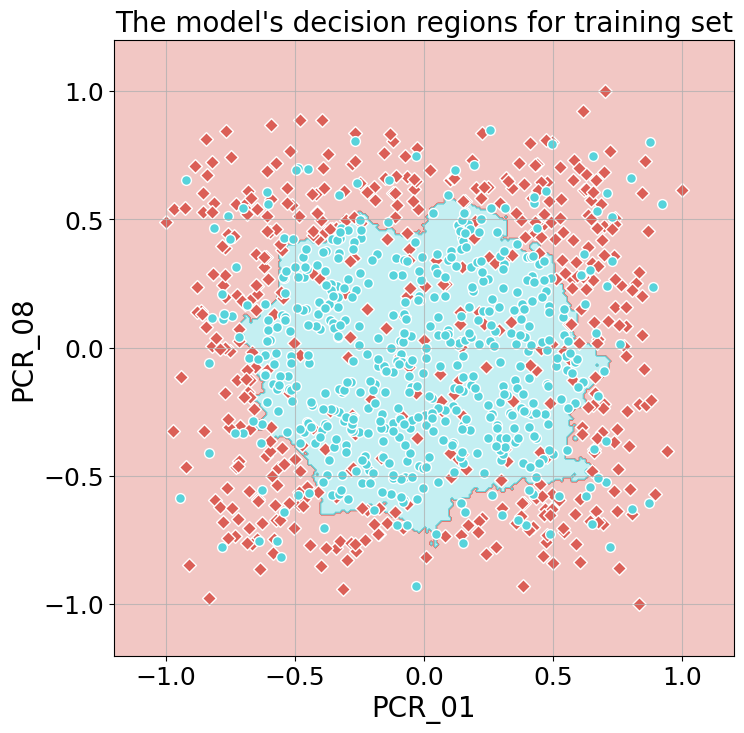

test 0.776


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


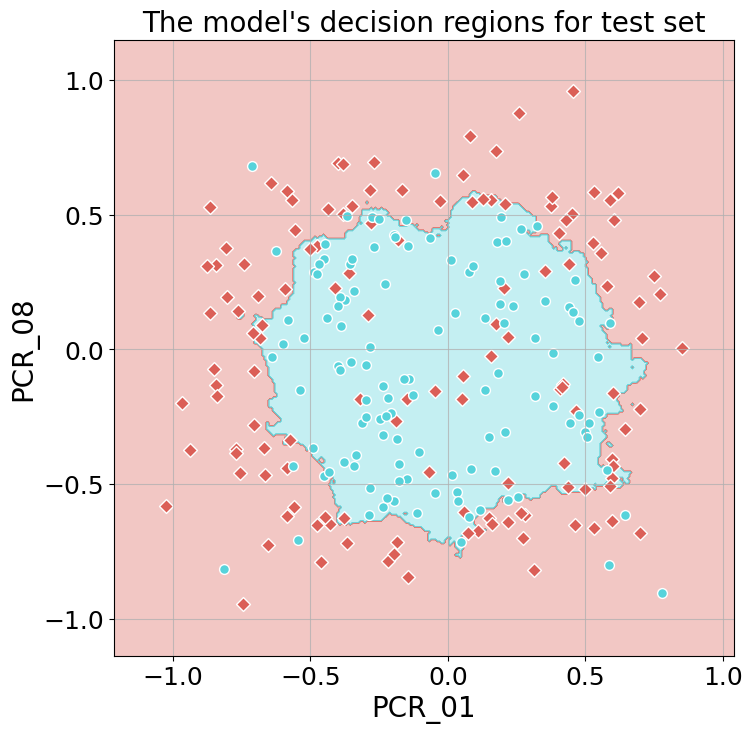

In [132]:
# Q3

# Create dataframe containing only the PCR 01 & 08 values
training_set_01_08 = training_set[['PCR_01', 'PCR_08']]
test_set_01_08 = test_set[['PCR_01', 'PCR_08']]

# Create kNN classifier with k=13 (best k value)
kNNClassifier = KNeighborsClassifier(n_neighbors=13)
kNNClassifier.fit(training_set_01_08, training_set['spread'])

# Visualize the decision regions for training set
print("train", kNNClassifier.score(training_set_01_08, training_set["spread"]))
visualize_clf(kNNClassifier, training_set_01_08, training_set['spread'], "The model's decision regions for training set", 'PCR_01', 'PCR_08')

# Visualize the decision regions for test set
print("test", kNNClassifier.score(test_set_01_08, test_set["spread"]))
visualize_clf(kNNClassifier, test_set_01_08, test_set['spread'], "The model's decision regions for test set", 'PCR_01', 'PCR_08')

## Part 2: Decision trees

### Visualization

Training set score:  0.678


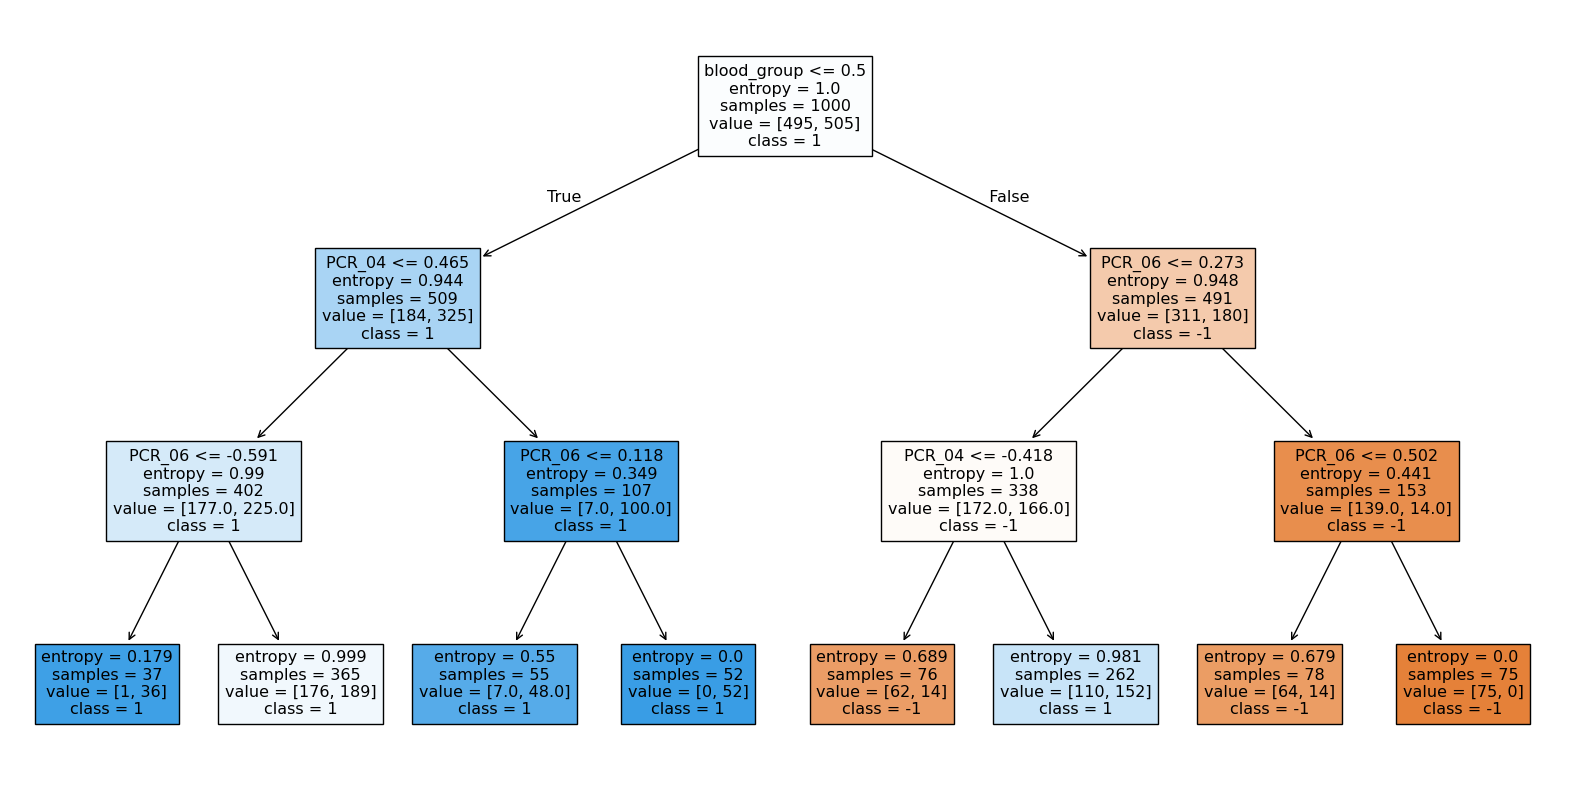

In [133]:
#Q5

# Create dataframe containing only the PCR 04, PCR 06 and blood group values
training_set_04_06_bg = training_set[['PCR_04', 'PCR_06', 'blood_group']]

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
tree.fit(training_set_04_06_bg, training_set['risk'])
print("Training set score: ", tree.score(training_set_04_06_bg, training_set["risk"]))

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=['PCR_04', 'PCR_06', 'blood_group'], class_names=['-1', '1'], filled=True)
plt.show()

### Model selection

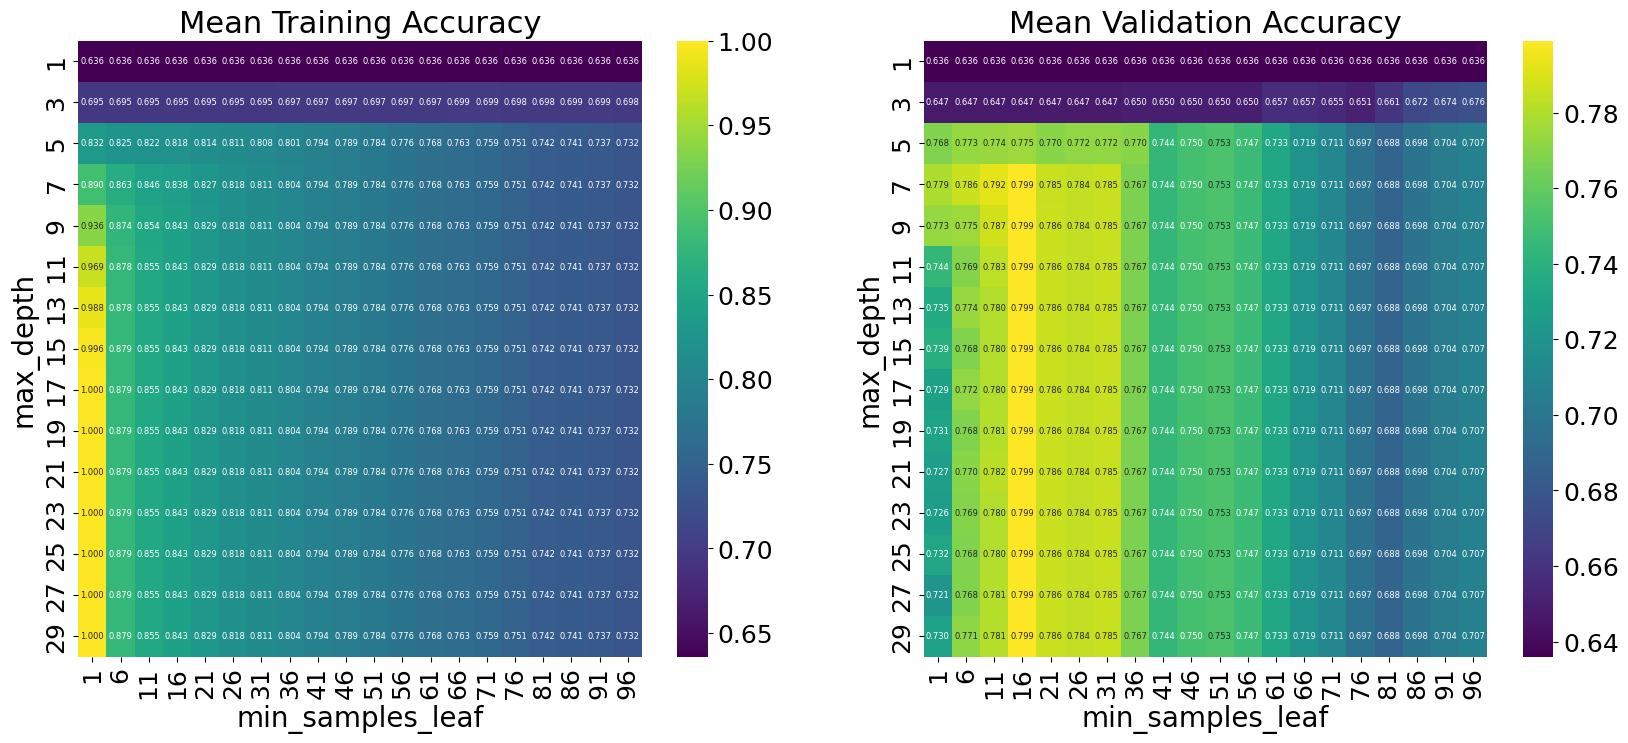

In [134]:
# Q6

# Grid search for best hyperparameters
param_grid = {'max_depth': range(1, 30, 2), 'min_samples_leaf': range(1, 101, 5)}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(training_set_04_06_bg, training_set['risk'])

# Get the results of the grid search
grid_results = pd.DataFrame(grid.cv_results_)
validation_data_frame = grid_results.pivot(index="param_max_depth", columns="param_min_samples_leaf", values="mean_test_score")
train_data_frame = grid_results.pivot(index="param_max_depth", columns="param_min_samples_leaf", values="mean_train_score")

# Plot the validation and train heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(train_data_frame, annot=True, fmt=".3f", cmap="viridis", ax=axes[0], annot_kws={"size": 6})
axes[0].set_title("Mean Training Accuracy")
axes[0].set_xlabel("min_samples_leaf")
axes[0].set_ylabel("max_depth")

sns.heatmap(validation_data_frame, annot=True, fmt=".3f", cmap="viridis", ax=axes[1], annot_kws={"size": 6})
axes[0].set_title("Mean Training Accuracy")
axes[1].set_title("Mean Validation Accuracy")
axes[1].set_xlabel("min_samples_leaf")
axes[1].set_ylabel("max_depth")

plt.show()

Test set score:  0.788


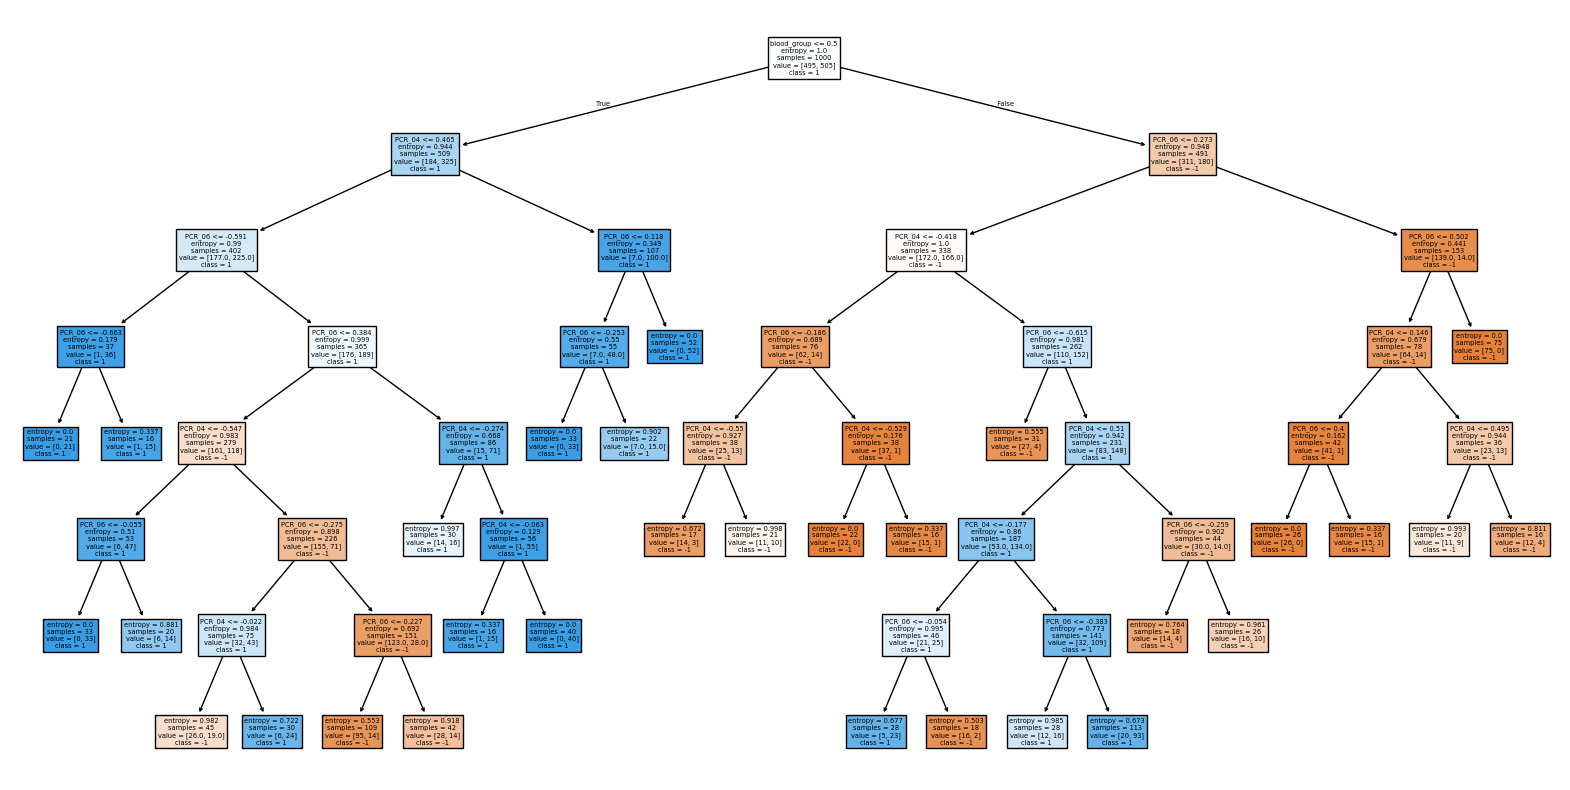

In [135]:
#Q8

# Create dataframe containing only the PCR 04, PCR 06 and blood group values
training_set_04_06_bg = training_set[['PCR_04', 'PCR_06', 'blood_group']]
test_set_04_06_bg = test_set[['PCR_04', 'PCR_06', 'blood_group']]

# Create decision tree classifier
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=7, min_samples_leaf=16)
decision_tree.fit(training_set_04_06_bg, training_set['risk'])
print("Test set score: ", decision_tree.score(test_set_04_06_bg, test_set["risk"]))

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=['PCR_04', 'PCR_06', 'blood_group'], class_names=['-1', '1'], filled=True)
plt.show()

## Part 3: Linear SVM and the Polynomial kernel

### Implementation of the loss and its gradient

In [136]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        norm = np.linalg.norm(w)
        
        # Adjust hinge_inputs shape to be 2D
        shaped_hinge_inputs = hinge_inputs.reshape(-1, 1)
        
        # create array of 1s and array of 0s, with the same shape as hinge_inputs
        ones = np.ones(shaped_hinge_inputs.shape)
        zeros = np.zeros(shaped_hinge_inputs.shape)
        
        # Calculate the value for each sample
        hinge_values = np.subtract(ones, shaped_hinge_inputs)
        loss = norm**2 + C * np.sum(np.maximum(zeros, hinge_values))

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # Compute Raw Decision Values
        classifier_vector = (np.dot(X, w) + b).reshape(-1, 1)
        classifier_vector = np.multiply(classifier_vector, y.reshape(-1, 1))
        
        # Identify Violations of the Margin and fix them to -1 and 0 for the rest
        fixed_vector = np.where(classifier_vector < 1, -1, 0)
        
        # This line calculates vec1, which will be -1 for misclassified points (where the margin is less than 1), and 0 otherwise.
        missclassify_vector = np.multiply(fixed_vector, y.reshape(-1, 1))
        
        g_w = 2*w + C * np.sum(np.multiply(X, missclassify_vector.reshape(-1, 1)), axis=0)
        g_b = C * np.sum(np.multiply(fixed_vector,y))

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]
        
        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step (value - learning rate*gradient)
            self.w = self.w - self.lr*g_w
            self.b = self.b - self.lr*g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # classifier vector
        classifier_vector = np.dot(X, self.w) + self.b
        y_pred = np.sign(classifier_vector)

        return y_pred


### Verifying your implementation: Numerical vs. analytical gradients

In [137]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


<>:41: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\d'
C:\Users\eyal\AppData\Local\Temp\ipykernel_38692\2696906511.py:41: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$\delta$', fontsize=18)


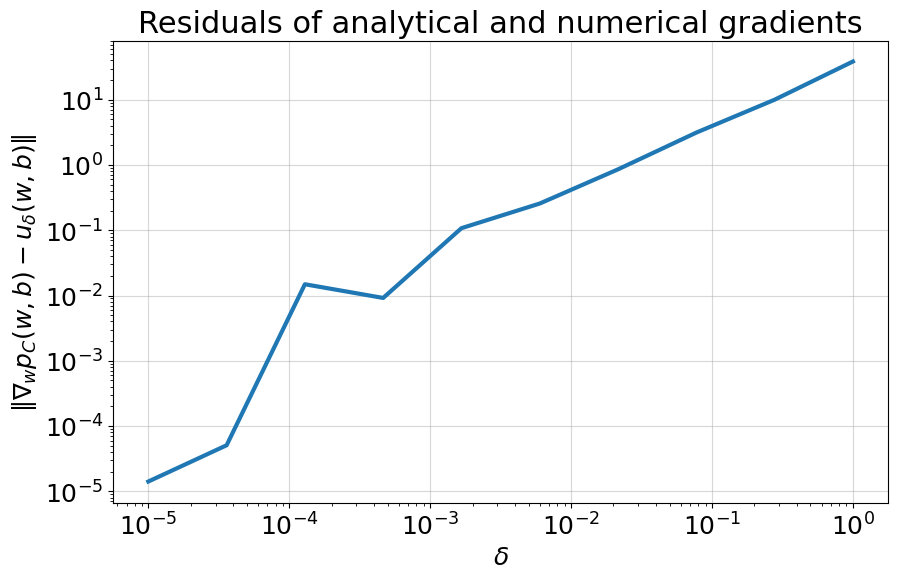

In [138]:
# Q9

X_data_train = np.array(training_set[["PCR_01", "PCR_08"]])
y_labels_train = np.array(training_set["spread"])
compare_gradients(X_data_train, y_labels_train, deltas=np.logspace(-5, 0, 10))

### Using a feature mapping


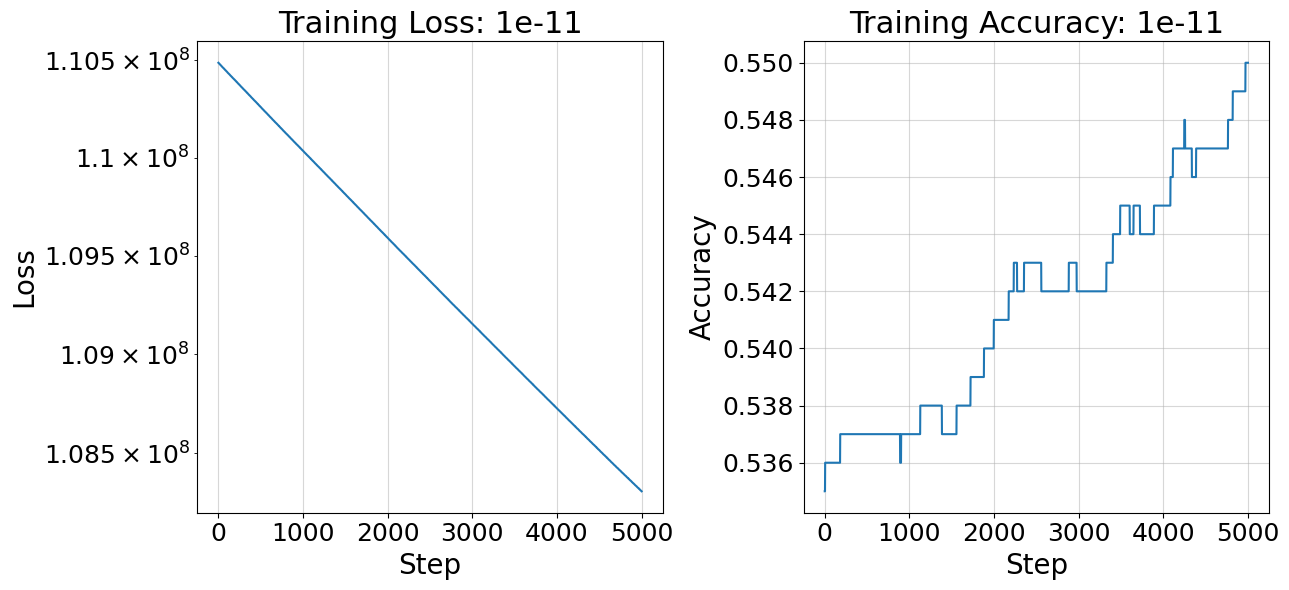

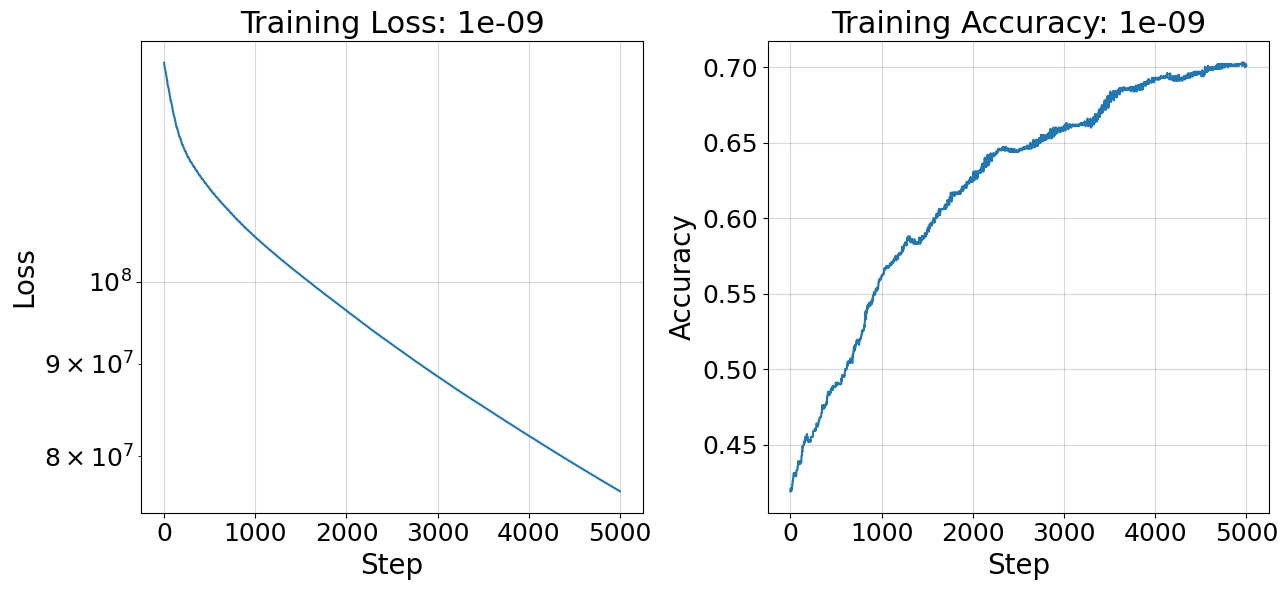

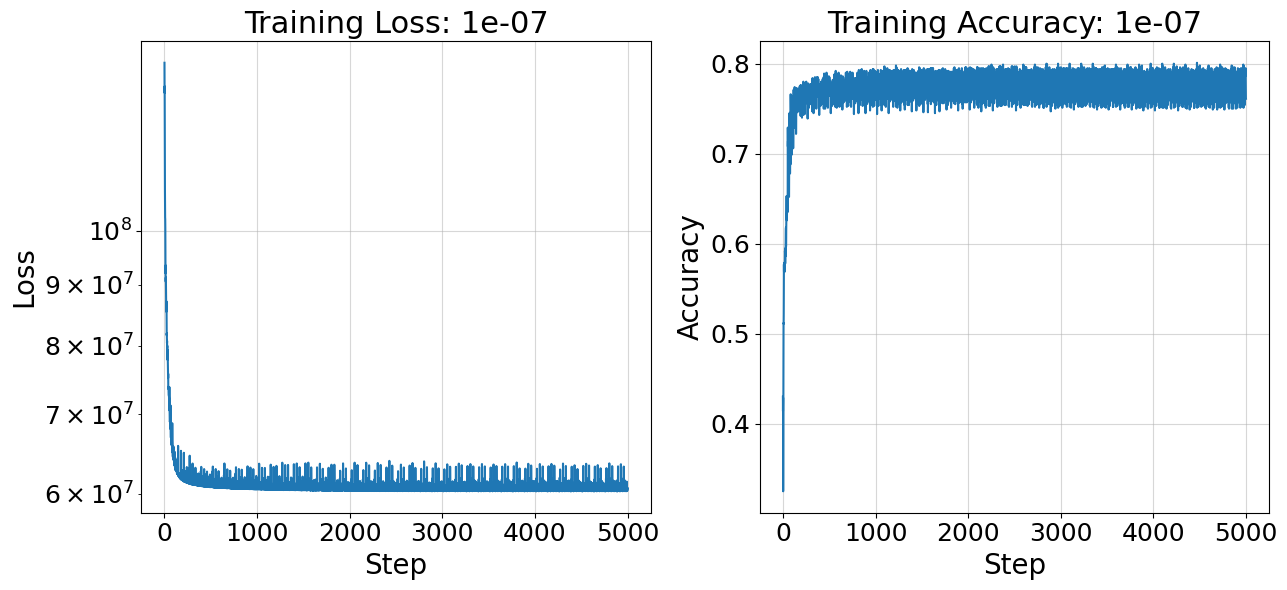

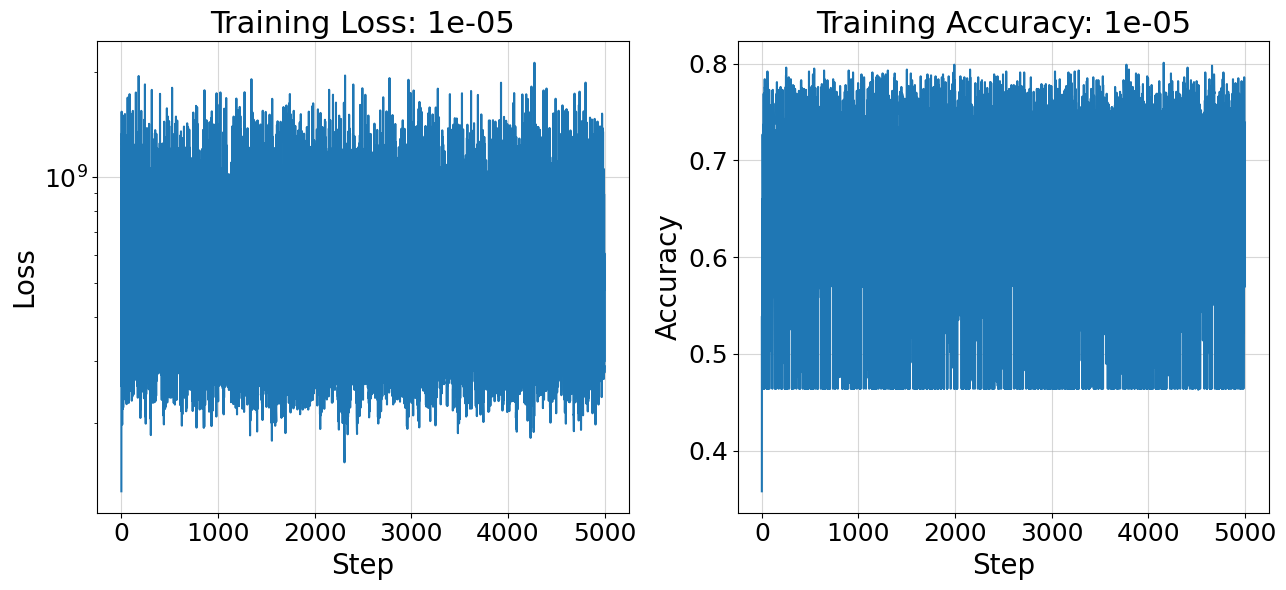

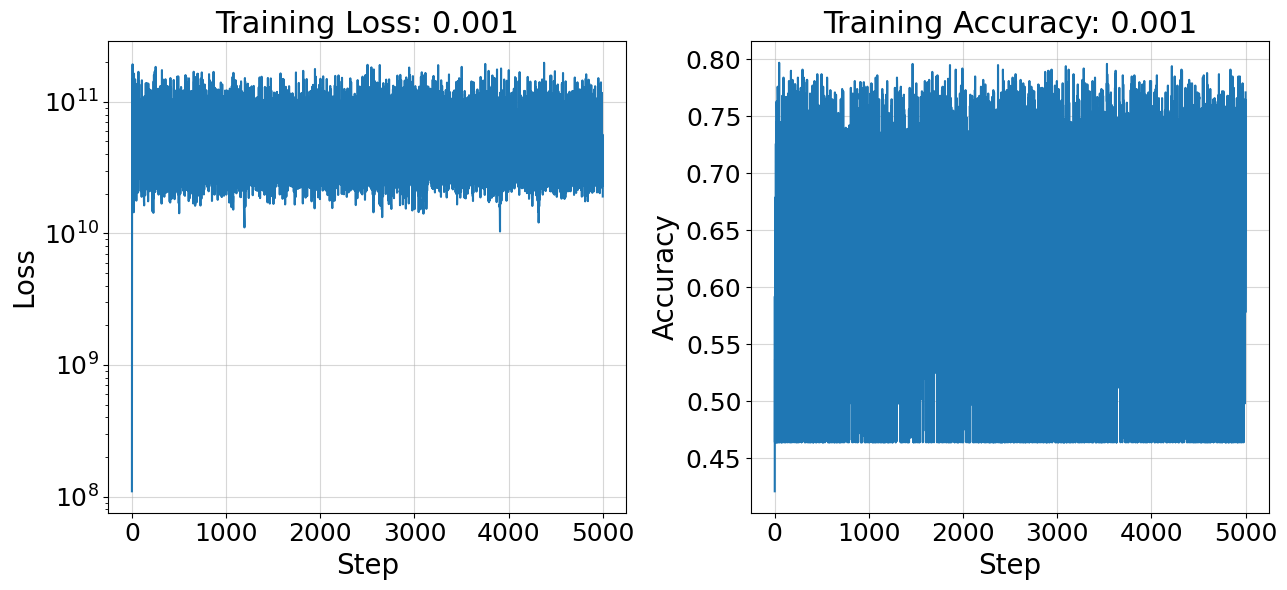

In [139]:
# Q11

C=1e5

learning_rate_range = np.logspace(-11, -3, 5)
X_train = np.array(training_set[["PCR_01", "PCR_08"]])
y_train = np.array(training_set["spread"]).reshape(-1,1)

for learning_rate in learning_rate_range:
    clf = SoftSVM(C=C, lr=learning_rate)
    X_train_poly = PolynomialFeatures(degree=3,).fit_transform(X_train)
    X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
    losses, accuracies = clf.fit_with_logs(X_train_poly, y_train, max_iter=5000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss: " + str(learning_rate))
    plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy: " + str(learning_rate))
    plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

Test score:  0.768
Train score:  0.772


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
C:\Users\eyal\AppData\Local\Packages\PythonS

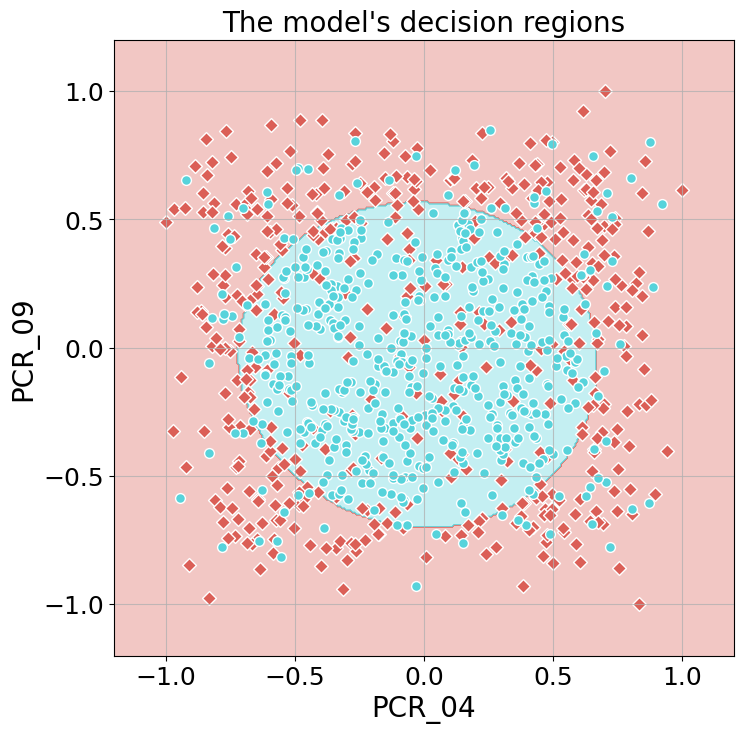

In [140]:
# Q12
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3,)),
('scaler', MinMaxScaler()),
('SVM', SoftSVM(C=1e5, lr=1e-07))])
svm_clf.fit(X_train, y_train)

# Show results and visualize the decision regions
print("Test score: ",svm_clf.score(test_set[['PCR_01', 'PCR_08']], test_set["spread"]))
print("Train score: ",svm_clf.score(training_set[['PCR_01', 'PCR_08']], training_set["spread"]))
visualize_clf(svm_clf, training_set[['PCR_01', 'PCR_08', 'spread']], training_set['spread'], "The model's decision regions", "PCR_04", "PCR_09")



## Part 4: The RBF kernel